In [38]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from general_graph_utils import *

# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif")
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

In [2]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

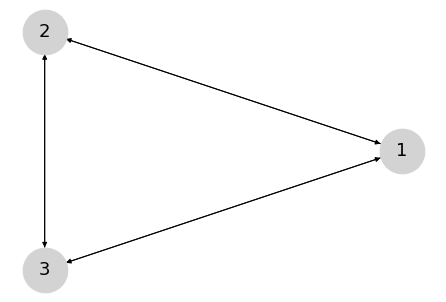

In [3]:
node_labels = {}
node_labels[1] = "1"
node_labels[2] = "2"
node_labels[3] = "3"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

In [4]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [5]:
label_dict, label_list = get_labels(G)

In [6]:
label_dict

{(1, 3): 0.24961,
 (1, 2): 235.3899,
 (2, 3): 122.10493,
 (2, 1): 0.05671,
 (3, 1): 881.82101,
 (3, 2): 619.09637}

In [7]:
label_list

array([2.4961000e-01, 2.3538990e+02, 1.2210493e+02, 5.6710000e-02,
       8.8182101e+02, 6.1909637e+02])

In [8]:
L = Laplacian_all(edge_list,label_list,node_list)
pi = steady_state_spectrum(L)

In [9]:
pi

array([0.03252789, 0.12096664, 0.84650547])

How do we enforce the initial conditions we want?

* Concentrate all probability at one node
* Enforce a flux in one direction

In [10]:
eigvals, eigvecs = scipy.linalg.eig(L)

In [11]:
eigvals

array([ 3.40795876e-14  +0.j        , -9.29359265e+02+162.68865406j,
       -9.29359265e+02-162.68865406j])

In [35]:
all_labels = np.zeros((100,6))
all_eigvals_real = np.zeros((100,3))
all_eigvals_complex = np.zeros((100,3))

all_eigvals_real[1]

array([0., 0., 0.])

In [36]:
for i in range(100):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    all_eigvals_real[i] = eigvals.real
    all_eigvals_complex[i] = eigvals.imag

In [40]:
t = np.around(np.arange(100.0,200.0,step=.01), decimals = 2)

In [59]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

In [43]:
list_result[0]

array([[0.25383928, 0.20031916, 0.20032832],
       [0.31031732, 0.33256426, 0.33256046],
       [0.4358434 , 0.46711657, 0.46711122]])

In [44]:
L

array([[-2.308000e-02,  1.500000e-03,  9.540000e-03],
       [ 1.699000e-02, -2.745782e+01,  1.954105e+01],
       [ 6.090000e-03,  2.745632e+01, -1.955059e+01]], dtype=float128)

In [52]:
P_0 = np.array([1,0,0])

In [53]:
P_0

array([1, 0, 0])

In [64]:
((L*P_0)[:,0])

array([-0.06924,  0.05097,  0.01827], dtype=float128)